# Overfitting

In [1]:
import pandas as pd
import numpy as np

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation

In [3]:
df = pd.read_csv('../Resources/meet_or_beat.csv')
df

,EPS,forecasted_eps,noOfEsts,after_total_returns,before_total_returns
0,2.01,1.67,11.0,0.051444,0.018585
1,0.17,0.19,6.0,0.112955,-0.000510
2,-0.07,0.14,4.0,0.077167,-0.046104
3,0.48,0.51,8.0,-0.006130,-0.004899
4,-0.24,-0.27,9.0,0.089762,-0.025466
...,...,...,...,...,...
71963,0.31,0.30,4.0,0.006035,0.016854
71964,-0.65,-0.66,3.0,0.179327,-0.039052
71965,0.27,0.28,3.0,0.059002,0.141599
71966,0.11,0.10,4.0,-0.035755,0.026346


### Preparing the Data

In [4]:
# Use qcut to group earnings results into 5 buckets
df['earnings_quantile'] = (pd.qcut(df['EPS'], q=5, labels=False))+1
# Verify buckets are approximately balanced 
# (Slight imbalance from ties is OK)
df['earnings_quantile'].value_counts()

earnings_quantile
2    14676
1    14555
5    14268
4    14251
3    14218
Name: count, dtype: int64

In [5]:
df.head()

,EPS,forecasted_eps,noOfEsts,after_total_returns,before_total_returns,earnings_quantile
0,2.01,1.67,11.0,0.051444,0.018585,5
1,0.17,0.19,6.0,0.112955,-0.000510,3
2,-0.07,0.14,4.0,0.077167,-0.046104,2
3,0.48,0.51,8.0,-0.006130,-0.004899,4
4,-0.24,-0.27,9.0,0.089762,-0.025466,1


In [6]:
# Save bucket ("quantile") value as the new  `y` variable
y_quantile = df['earnings_quantile']
y_quantile

0        5
1        3
2        2
3        4
4        1
        ..
71963    3
71964    1
71965    3
71966    2
71967    1
Name: earnings_quantile, Length: 71968, dtype: int64

In [7]:
# Save the unique count of categories for later use
number_of_classes = len(y_quantile.unique())
number_of_classes

5

In [8]:
# Encode quantiles into labels
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_quantile)
encoded_y = encoder.transform(y_quantile)
encoded_y

array([4, 2, 1, ..., 2, 1, 0], dtype=int64)

In [9]:
# Encode labels into categories
from tensorflow.keras.utils import to_categorical
y_categorical = to_categorical(encoded_y, num_classes=number_of_classes)
y_categorical

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [10]:
# Specify X (predictor) variables
X = df[['forecasted_eps',
              'before_total_returns','noOfEsts']]
X.head(3)

,forecasted_eps,before_total_returns,noOfEsts
0,1.67,0.018585,11.0
1,0.19,-0.000510,6.0
2,0.14,-0.046104,4.0


In [11]:
# Split into training and testing windows
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, random_state=1)

In [12]:
# Preview the `y_train` values
y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [13]:
# Save the count of unique predictor variables for use in model
number_of_predictors = len(X.columns)
len(X.columns)

3

### Building the Model

In [14]:
# Import the `Dropout` layer
from keras.layers import Dropout
# Import regularizers
from keras.regularizers import l1, l2

In [15]:
# Build the Model
model = Sequential()
# Add a dense layer (as before)
model.add(Dense(10, input_dim=number_of_predictors, activation='relu'))
# Now add a dropout layer
model.add(Dropout(.2,input_shape=(10,)))
# Add regularization to another dense layer
model.add(Dense(5, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

c:\Users\pablo\anaconda3\envs\dev\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\pablo\anaconda3\envs\dev\lib\site-packages\keras\src\layers\regularization\dropout.py:42: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# Add the final output layer
# (Set the # of possible outputs equal to the number classes)
model.add(Dense(number_of_classes, activation='softmax'))

In [17]:
# Compile the model
model.compile(loss="categorical_crossentropy", 
              optimizer= "adam", 
              metrics=['categorical_accuracy'])

In [18]:
# Summarise the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125 (500.00 B)

 Trainable params: 125 (500.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Add in validation loss to select the number of epochs
# Fit the model
number_of_epochs = 25
model.fit(X_train,y_train, 
                    epochs=number_of_epochs,
                    batch_size=1000,
                      validation_split=0.2,
                    shuffle=True)

Epoch 1/25


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - categorical_accuracy: 0.2036 - loss: 1.9099 - val_categorical_accuracy: 0.2406 - val_loss: 1.6221
Epoch 2/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.2387 - loss: 1.6949 - val_categorical_accuracy: 0.3643 - val_loss: 1.5327
Epoch 3/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3087 - loss: 1.5958 - val_categorical_accuracy: 0.3972 - val_loss: 1.4670
Epoch 4/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3400 - loss: 1.5367 - val_categorical_accuracy: 0.4145 - val_loss: 1.4125
Epoch 5/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3675 - loss: 1.4813 - val_categorical_accuracy: 0.4343 - val_loss: 1.3603
Epoch 6/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3861 - loss: 1.4275 - val_categorical_accuracy: 0.4620 - val_loss: 1.3086
Epoch 7/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.4047 - loss: 1.3776 - val_categoric

In [20]:
# Save model history across epochs
model_history = model.history.history
model_history.keys()

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss'])

In [21]:
# View `categorical_accuracy` for the training dataset
model_history['categorical_accuracy']

[0.21104678511619568,
 0.25803613662719727,
 0.3188050091266632,
 0.35164427757263184,
 0.3712598383426666,
 0.391940712928772,
 0.4084993004798889,
 0.4255210757255554,
 0.4460861384868622,
 0.46199628710746765,
 0.48816582560539246,
 0.5224177837371826,
 0.5588003993034363,
 0.5874941945075989,
 0.6063918471336365,
 0.625474750995636,
 0.6431681513786316,
 0.6531727910041809,
 0.6680176258087158,
 0.6773043274879456,
 0.6812876462936401,
 0.6886058449745178,
 0.6933302283287048,
 0.7042843699455261,
 0.7016906142234802]

<Axes: title={'center': 'Performance Across Training and Validation'}>

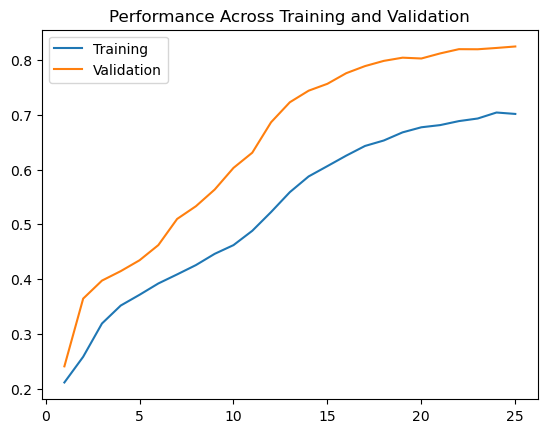

In [22]:
# Save accuracy for training and validation set across epochs
training_results = pd.DataFrame(index=range(1,number_of_epochs+1))
training_results['Training'] = model_history['categorical_accuracy']
training_results['Validation'] = model_history['val_categorical_accuracy']
training_results.plot(title = 'Performance Across Training and Validation')